# Navigation Project (DQN)
---
A DQN agent to solve the Navigation Project as part of [Udacity's Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import math 
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from dqn_agent import Agent

from unityagents import UnityEnvironment

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below. Depending on the operating system, the ``BBANANA_PATH`` to the Unity environment migth need to change.

In [2]:
BANANA_PATH = "Banana.app"

env = UnityEnvironment(file_name=BANANA_PATH,worker_id=1, seed=1) # Otherwise Unity crashes...
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of actions: 4
States have length: 37


### 3. Simplify the Interface of the Environment

The environment returns a ``BrainInfo`` object with attributes for the new state, the reward, and other information. The following helper function unpacks the values for ``next_state``, ``reward``, and ``done``.

In [3]:
def open_brain_surgery(brain):
    """Helper function to unpack BrainInfo Object.
    
    Params
    ======
        brain (BrainInfo) : Single BrainInfo Object
    """
    state = brain.vector_observations[0]
    reward = brain.rewards[0]
    done = brain.local_done[0]
    return (state, reward, done)

### 4. Define the Training Function

The cell below trains the agent from scratch and saves the checkpoints when the environment is solved (score > 13). If ``highscore = True``, the agent continues to train until the maximum number of episodes is reached and saves the model whenever a new highscore is achieved.

In [4]:
def dqn(n_episodes=2000, max_t=1000, 
        eps_start=1.0, eps_end=0.01, eps_decay=0.95, highscore=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        highscore (bool): If True training continues after the environment has been solved
    """
    max_score = 12                     # keep track of highest winning score
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _, done = open_brain_surgery(env.reset(train_mode=True)[brain_name])
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        avg_score = np.mean(scores_window)
        if i_episode % 100 == 0:          # report training progress
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
        if math.floor(avg_score)>max_score:
            if max_score == 12:           # environment solved (the average score is rounded down)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            else:                         # new high score achieved
                print('\nNew high score after {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            max_score = math.floor(avg_score)
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_'+agent.flavor+'.pth')
            if not highscore:
                break
    return scores


def plot_scores(scores):
    """Plot Scores.
    
    Params
    ======
        scores (list): list of score for each episode
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 5. Train the Agents

The ``Agent`` class currently supports four types of agents that can be passed using the ``flavor`` parameter:
- ``plain``: Standard DQN agent.
- ``double``: Double DQN agent.
- ``dueling``: Dueling DQN agent.
- ``double-dueling``: Double dueling DQN agent.

The number of layers (at least one) and their neurons can be passed in a list to the ``hidden_sizes`` parameter. The default is ``hidden_sizes = [64,64]``, i.e., two layers with 64 neurons each.

Hyperparameters for the learning process can be changed at the beginning of the ``dqn_agent.py`` file and are set to:

- ``BUFFER_SIZE = int(1e5)``

- ``BATCH_SIZE = 64``

- ``GAMMA = 0.99``

- ``TAU = 1e-2``

- ``LR = 5e-4``

- ``UPDATE_EVERY = 4``

Let's see how succesful these agents navigate the environment:

#### 5.1 Plain DQN

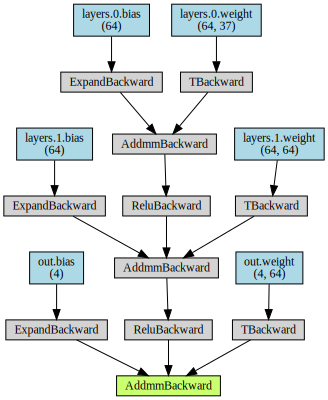

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, 
              seed=0, hidden_sizes = [64, 64], flavor='plain')
agent.show_network()

Episode 100	Average Score: 3.66
Episode 200	Average Score: 11.17
Episode 300	Average Score: 11.08
Episode 400	Average Score: 12.56

Environment solved in 364 episodes!	Average Score: 13.06



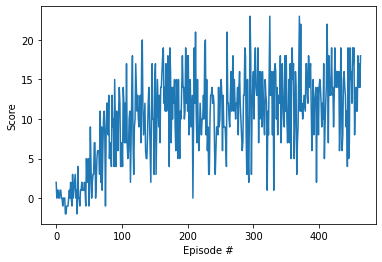

In [6]:
scores = dqn()
plot_scores(scores)

#### 5.2 Double DQN

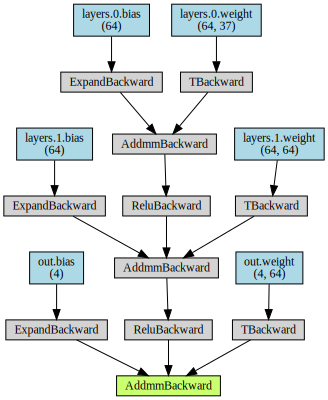

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, 
              seed=0, hidden_sizes = [64, 64], flavor='double')
agent.show_network()

Episode 100	Average Score: 8.05
Episode 200	Average Score: 12.35
Episode 300	Average Score: 12.58

Environment solved in 258 episodes!	Average Score: 13.04



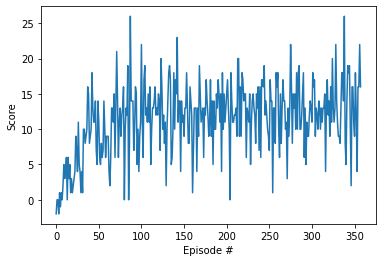

In [8]:
scores = dqn()
plot_scores(scores)

#### 5.3 Dueling DQN

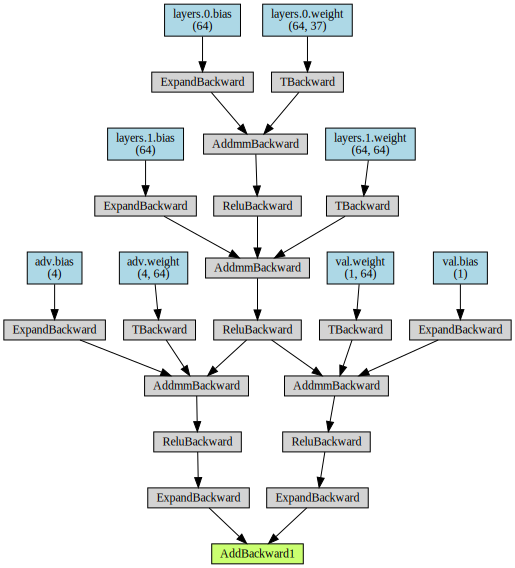

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, 
              seed=0, hidden_sizes = [64, 64], flavor='dueling')
agent.show_network()

Episode 100	Average Score: 4.62
Episode 200	Average Score: 12.33
Episode 300	Average Score: 11.73

Environment solved in 261 episodes!	Average Score: 13.01



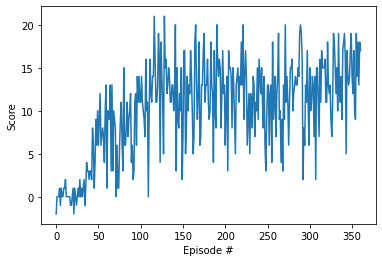

In [10]:
scores = dqn()
plot_scores(scores)

#### 5.4 Double Dueling DQN

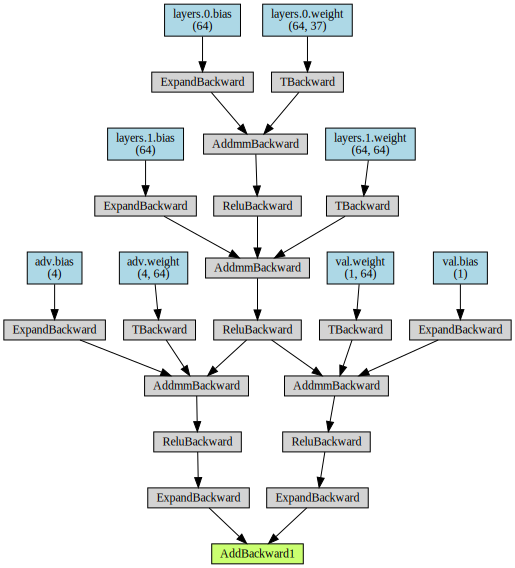

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, 
              seed=0, hidden_sizes = [64, 64], flavor='double-dueling')
agent.show_network()

Episode 100	Average Score: 8.87
Episode 200	Average Score: 12.45

Environment solved in 180 episodes!	Average Score: 13.00



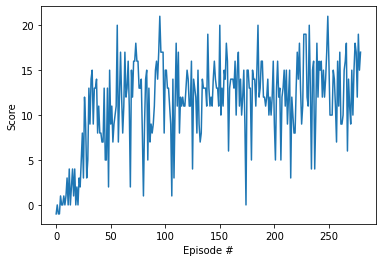

In [12]:
scores = dqn()
plot_scores(scores)

### 6. Watch the Trained Agents

The next cell loads the checkpoint for a trained agent to watch it in action.

In [13]:
# load the weights from file
def watch_agent(flavor, file_name = None):
    """Watch Trained Agent.
    
    Params
    ======
    flavor (str): flavor of the network - plain, double, dueling, double-dueling
    file_name (path): path to a trained model compatible with the flavor (optional)
    """
    print('Flavor: {}'.format(flavor))
    if file_name is None:
        file_name = 'checkpoint_'+flavor+'.pth'
        
    # Load agent and weights
    agent = Agent(state_size=state_size, action_size=action_size, 
                  seed=0, flavor=flavor)
    agent.qnetwork_local.load_state_dict(torch.load(file_name))

    # Initiate and run
    state, _, done = open_brain_surgery(env.reset(train_mode=False)[brain_name])
    score = 0                                          
    while True:
        action = agent.act(state)
        next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:       
            break    
    print('Game score: {}'.format(score))
    
watch_agent('double-dueling')

Flavor: double-dueling
Game score: 14.0


In [14]:
env.close()

### 7. Possible Extensions

Performance and training speed could potentially be increased further:
1. The hyperparameters used are likely not optimal. Additional tuning or grid search could be used to make the training more efficient.
2. The current network architecture is surprisingly effective, given its simplicity. However, more elaborate architectures with additional layers of neurons might yield considerable performance gains.
3. There have been many improvements to the DQN algorithm, some of which have been consolidated in the [Rainbow Agent](https://arxiv.org/pdf/1710.02298.pdf). In addition to Dueling and Double DQN implemented here, the following additional improvements:
  * The ``ReplayBuffer`` class could be appended to support prioritized experience replay.
  * Noisy layers in the network could lead to more efficient exploration.
  * Distributional DQN would aim to learn the distribution of rewards instead of the mean. This is presumably less important for this application, as there is relatively little uncertainy within an episode of the environment.
  * The loss function could be changed to support multi-step learning.